In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset
from sklearn.preprocessing import OneHotEncoder

In [ ]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
#%pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "Metro_Interstate_Traffic_Volume.csv"

# Load the latest version
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "anshtanwar/metro-interstate-traffic-volume",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

df['temp'] = (df['temp'] - 273.15) * 9.0/5 + 32.0
df['date_time'] = pd.to_datetime(df['date_time'], format="%d-%m-%Y %H:%M")
df['holiday'] = df['holiday'].notna().astype(int)

print("First 5 records:", df.head())

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
First 5 records:    traffic_volume  holiday    temp  rain_1h  snow_1h  clouds_all weather_main  \
0            5545        0  59.234      0.0      0.0          40       Clouds   
1            4516        0  61.178      0.0      0.0          75       Clouds   
2            4767        0  61.574      0.0      0.0          90       Clouds   
3            5026        0  62.564      0.0      0.0          90       Clouds   
4            4918        0  64.382      0.0      0.0          75       Clouds   

  weather_description           date_time  
0    scattered clouds 2012-10-02 09:00:00  
1       broken clouds 2012-10-02 10:00:00  
2     overcast clouds 2012-10-02 11:00:00  
3     overcast clouds 2012-10-02 12:00:00  
4       broken clouds 2012-10-02 13:00:00  


In [ ]:
df['hour'] = df['date_time'].dt.hour
df['day_of_week'] = df['date_time'].dt.dayofweek
df['month'] = df['date_time'].dt.month
df['year'] = df['date_time'].dt.year

df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

df['is_rush_hour'] = ((df['hour'] >= 7) & (df['hour'] <= 9) | 
                       (df['hour'] >= 16) & (df['hour'] <= 18)).astype(int)

df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

In [4]:
df.sort_values(by='date_time')
df = df.groupby(by='date_time').first()

n = len(df)
train_end = int(n * 0.6)
val_end = int(n * 0.8)
feature_cols = ['traffic_volume','temp','rain_1h','snow_1h','clouds_all', 'hour_sin', 'hour_cos', 'holiday']
target_col = 'traffic_volume'

train_df = df.iloc[:train_end]
val_df = df.iloc[train_end:val_end]
test_df = df.iloc[val_end:]

In [5]:
def create_multi_scale_sequences(df, feature_cols, target_col,
                                 cont_len=8, num_days=7, num_weeks=2):
    """
    Creates continuity, daily periodicity, and weekly periodicity windows.

    cont_len: number of recent hours for continuity
    num_days: number of past days to include (full daily patterns)
    num_weeks: number of past weeks to include (full weekly patterns)
    """

    X_cont, X_daily, X_weekly, y = [], [], [], []
    features = df[feature_cols].values
    target = df[target_col].values
    n = len(df)

    daily_len = 24
    weekly_len = 168

    # required history length
    min_index = max(cont_len,
                    num_days * daily_len, #+ cont_len,
                    num_weeks * weekly_len) #+ cont_len)

    for i in range(min_index, n): # each iteration uses min_index rows, so we start at min_index

        # Continuity: last cont_len hours
        cont = features[i - cont_len : i]

        # Daily: last num_days full daily patterns
        # each day block is 24 hours long
        daily = []
        for d in range(1, num_days+1):
            #start_idx = i - cont_len - d * daily_len
            #end_idx = i - cont_len - (d - 1) * daily_len
            #day_block = features[start_idx : end_idx]
            day_block = features[i - d*daily_len : i - (d-1)*daily_len] # [i-24:i], [i-48:i-24], ...
            daily.append(day_block) # list of day arrays
        daily = np.stack(daily)  # (num_days, 24, num_features)

        # Weekly: last num_weeks full weekly patterns
        weekly = []
        for w in range(1, num_weeks+1):
            week_block = features[i - w*weekly_len : i - (w-1)*weekly_len]
            #start_idx = i - cont_len - w * weekly_len
            #end_idx = i - cont_len - (w - 1) * weekly_len
            #week_block = features[start_idx : end_idx]
            weekly.append(week_block)
        weekly = np.stack(weekly)  # (num_weeks, 168, num_features)

        X_cont.append(cont)
        X_daily.append(daily)
        X_weekly.append(weekly)
        y.append(target[i])

    return (
        np.array(X_cont),      # (N, cont_len, F), F=7
        np.array(X_daily),     # (N, num_days, 24, F), F=7
        np.array(X_weekly),    # (N, num_weeks, 168, F), F=7
        np.array(y)
    )

In [6]:
weather_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit on training data
train_weather_encoded = weather_encoder.fit_transform(train_df[['weather_main']])
val_weather_encoded = weather_encoder.transform(val_df[['weather_main']])
test_weather_encoded = weather_encoder.transform(test_df[['weather_main']])

# Get feature names
weather_feature_names = weather_encoder.get_feature_names_out(['weather_main'])
print(f"\nWeather features: {weather_feature_names}")


Weather features: ['weather_main_Clear' 'weather_main_Clouds' 'weather_main_Drizzle'
 'weather_main_Fog' 'weather_main_Haze' 'weather_main_Mist'
 'weather_main_Rain' 'weather_main_Smoke' 'weather_main_Snow'
 'weather_main_Squall' 'weather_main_Thunderstorm']


In [ ]:
feature_cols = ['holiday','rain_1h','snow_1h','is_rush_hour','is_weekend','temp','hour_sin','hour_cos','day_sin','day_cos','month_sin','month_cos', 'clouds_all'] + list(weather_feature_names)

binary_features = ['holiday','rain_1h','snow_1h','is_rush_hour','is_weekend'] # leave these as is!!
numeric_features = ['temp','hour_sin','hour_cos','day_sin','day_cos','month_sin','month_cos', 'clouds_all']  # continuous features to scale [0,1]

scaler_features = MinMaxScaler()

train_scaled_numeric = scaler_features.fit_transform(train_df[numeric_features].values.astype('float32'))
val_scaled_numeric = scaler_features.transform(val_df[numeric_features].values.astype('float32'))
test_scaled_numeric = scaler_features.transform(test_df[numeric_features].values.astype('float32'))

train_scaled = np.hstack([train_df[binary_features].values.astype('float32'), train_scaled_numeric, train_weather_encoded])
val_scaled   = np.hstack([val_df[binary_features].values.astype('float32'), val_scaled_numeric, val_weather_encoded])
test_scaled  = np.hstack([test_df[binary_features].values.astype('float32'), test_scaled_numeric, test_weather_encoded])

train_scaled_df = pd.DataFrame(train_scaled, columns=binary_features + numeric_features + list(weather_feature_names))
val_scaled_df = pd.DataFrame(val_scaled, columns=binary_features + numeric_features + list(weather_feature_names))
test_scaled_df = pd.DataFrame(test_scaled, columns=binary_features + numeric_features + list(weather_feature_names))

target_col = 'traffic_volume'
target_scaler = MinMaxScaler()

train_target_scaled = target_scaler.fit_transform(train_df[[target_col]].values.astype('float32'))
val_target_scaled   = target_scaler.transform(val_df[[target_col]].values.astype('float32'))
test_target_scaled  = target_scaler.transform(test_df[[target_col]].values.astype('float32'))

train_scaled_df[target_col] = train_target_scaled
val_scaled_df[target_col] = val_target_scaled
test_scaled_df[target_col] = test_target_scaled


In [8]:
X_cont, X_daily, X_weekly, y = create_multi_scale_sequences(train_scaled_df, feature_cols, 'traffic_volume')
X_cont_val, X_daily_val, X_weekly_val, y_val = create_multi_scale_sequences(val_scaled_df, feature_cols, 'traffic_volume')
X_cont_test, X_daily_test, X_weekly_test, y_test = create_multi_scale_sequences(test_scaled_df, feature_cols, 'traffic_volume')

In [9]:
X_weekly.shape

(24009, 2, 168, 24)

In [10]:
class TrafficDataset(Dataset):
    def __init__(self, X_cont, X_daily, X_weekly, y):
        # Convert to tensors
        self.X_cont = torch.tensor(X_cont, dtype=torch.float32).permute(0,2,1)

        self.X_daily = torch.tensor(X_daily, dtype=torch.float32).permute(0, 3, 1, 2)  # (N, F, num_days, 24)

        self.X_weekly = torch.tensor(X_weekly, dtype=torch.float32).permute(0, 3, 1, 2)  # (N, F, num_weeks, 168)

        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # shape (batch,1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X_cont[idx], self.X_daily[idx], self.X_weekly[idx], self.y[idx]


In [11]:
train_dataset = TrafficDataset(X_cont, X_daily, X_weekly, y)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)

val_dataset = TrafficDataset(X_cont_val, X_daily_val, X_weekly_val, y_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=512, shuffle=True)

test_dataset = TrafficDataset(X_cont_test, X_daily_test, X_weekly_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=False) # leaving test as non-shuffled

In [12]:
X_weekly.shape

(24009, 2, 168, 24)

In [ ]:
class BranchCNN(nn.Module):
    def __init__(self, in_channels=1, kernel_size=3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, 32, kernel_size=kernel_size, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=kernel_size, padding=1)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=kernel_size, padding=1)
        
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.flatten(start_dim=1)  # flatten for fusion
        x = self.dropout(x)
        
        return x

class BranchCNN2D(nn.Module):
    def __init__(self, in_channels=1, kernel_size=(3,3)):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=kernel_size, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=kernel_size, padding=1)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)  # Reduce dimensions
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.maxpool(x)  # Reduce again
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.adaptive_pool(x)  # (batch, 128, 1, 1)
        x = x.flatten(start_dim=1)  # (batch, 128)
        x = self.dropout(x)
        
        return x

class MF_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # three branches
        self.cont_branch = BranchCNN(in_channels=len(feature_cols), kernel_size=3)
        self.daily_branch = BranchCNN2D(in_channels=len(feature_cols))
        self.weekly_branch = BranchCNN2D(in_channels=len(feature_cols), kernel_size=(2,2))

        dummy_cont = torch.zeros(1, len(feature_cols), 8) # same values as the params in sliding window funct
        dummy_daily = torch.zeros(1, len(feature_cols), 7, 24)
        dummy_weekly = torch.zeros(1, len(feature_cols), 2, 168)

        f1 = self.cont_branch(dummy_cont)
        f2 = self.daily_branch(dummy_daily)
        f3 = self.weekly_branch(dummy_weekly)

        fusion_dim = f1.shape[1] + f2.shape[1] + f3.shape[1]

        # Fully connected layer
        self.fc = nn.Linear(fusion_dim, 1)

    def forward(self, cont, daily, weekly, external=None):
        # cont, daily, weekly: [batch, 1, time, space]
        f1 = self.cont_branch(cont)
        f2 = self.daily_branch(daily)
        f3 = self.weekly_branch(weekly)

        if external is not None:
            fused = torch.cat([f1, f2, f3, external], dim=1)
        else:
            fused = torch.cat([f1, f2, f3], dim=1)

        out = self.fc(fused)  # linear output
        return out

In [14]:
torch.cuda.is_available(), torch.cuda.get_device_name(0)

(True, 'NVIDIA A40')

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def test(network, test_loader, loss_function):
    network.eval() #updates any network layers that behave differently in training and execution
    test_loss = 0.0
    total_samples = 0
    with torch.no_grad():
        for cont, daily, weekly, target in test_loader:
            cont = cont.to(device)
            daily = daily.to(device)
            weekly = weekly.to(device)
            target = target.to(device)
            output = network(cont, daily, weekly)
            test_loss += loss_function(output, target).item() * target.size(0)
            # pred = output.data.max(1, keepdim=True)[1]
            # num_batches += 1
            total_samples += target.size(0)
    # test_loss /= num_batches
    #print('\nTest set: Avg. loss: {:.4f})\n'.format(test_loss))
    return test_loss / total_samples

def logResults(epoch, num_epochs, train_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, print_interval=1000):
    if (epoch%print_interval == 0):  print('Epoch [%d/%d], Train Loss: %.4f, Test Loss: %.4f' %(epoch+1, num_epochs, train_loss, test_loss))
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    epoch_counter.append(epoch)

def graphLoss(epoch_counter, train_loss_hist, test_loss_hist, loss_name="Loss", start = 0):
    fig = plt.figure()
    plt.plot(epoch_counter[start:], train_loss_hist[start:], color='blue')
    plt.plot(epoch_counter[start:], test_loss_hist[start:], color='red')
    plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
    plt.xlabel('#Epochs')
    plt.ylabel(loss_name)

def computeRegressionMetrics(networkModel, data_loader, label_text="", target_scaler=None):
    networkModel.eval()
    preds_all = []
    trues_all = []

    with torch.no_grad():
        for cont, daily, weekly, target in data_loader:
            cont = cont.to(device)
            daily = daily.to(device)
            weekly = weekly.to(device)
            target = target.to(device)
            output = networkModel(cont, daily, weekly)
            output = output.view_as(target)

            preds_all.append(output.cpu())
            trues_all.append(target.cpu())

    # Concatenate all batches
    preds_scaled = torch.cat(preds_all, dim=0).numpy().reshape(-1, 1)
    trues_scaled = torch.cat(trues_all, dim=0).numpy().reshape(-1, 1)

    # If scaler is provided, inverse-transform to original scale
    if target_scaler is not None:
        # Must be 2D array
        preds = target_scaler.inverse_transform(preds_scaled)
        trues = target_scaler.inverse_transform(trues_scaled)
    else:
        preds = preds_scaled
        trues = trues_scaled

    # Compute metrics on original scale
    mse_loss = ((preds - trues) ** 2).mean()
    rmse = mse_loss ** 0.5
    mae_loss = (abs(preds - trues)).mean()
    with np.errstate(divide='ignore', invalid='ignore'):
        mape = np.mean(np.abs((trues - preds) / np.where(trues==0, 1, trues))) * 100

    print(f"\n{label_text}: MSE: {mse_loss:.4f}, RMSE: {rmse:.4f}, MAE: {mae_loss:.4f}), MAPE: {mape:.4f}")
    return mse_loss, rmse, mae_loss, preds.flatten(), trues.flatten()

In [17]:
def train(network,  data_generator, loss_function, optimize, batch_logging = 100):
    network.train() #updates any network layers that behave differently in training and execution
    avg_loss = 0
    num_batches = 0
    for batch, (cont, daily, weekly, target_output) in enumerate(data_generator):
        cont = cont.to(device)
        daily = daily.to(device)
        weekly = weekly.to(device)
        target_output = target_output.to(device)
        optimizer.zero_grad()                            # Gradients need to be reset each batch
        prediction = network(cont, daily, weekly)        # Forward pass: compute the output class given a image
        loss = loss_function(prediction, target_output)  # Compute the loss: difference between the output and correct result
        loss.backward()                                  # Backward pass: compute the gradients of the model with respect to the loss
        optimizer.step()
        avg_loss += loss.item()
        num_batches += 1
        if ((batch+1)%batch_logging == 0): #Print info every "batch_logging" steps [NEW]
            print('Batch [%d/%d], Train Loss: %.4f' %(batch+1, len(data_generator.dataset)/len(target_output), avg_loss/num_batches))
    return avg_loss/num_batches

In [ ]:
def trainAndGraph(network, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, early_stopping=True, logging_interval=1):
    #Arrays to store training history
    test_loss_history = []
    epoch_counter = []
    train_loss_history = []
    best_loss = 99999999
    for epoch in range(num_epochs):
        avg_loss = train(network, training_generator, loss_function, optimizer)
        test_loss = test(network, testing_generator, loss_function)
        logResults(epoch, num_epochs, avg_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, logging_interval)
        #if (early_stopping and test_loss > last_loss):
          #break
        if (test_loss < best_loss):
            best_loss = test_loss
            torch.save(network.state_dict(), "msi_model.pth")
        # old_params = network.parameters()

    graphLoss(epoch_counter, train_loss_history, test_loss_history)

Loaded Data
Epoch [1/50], Train Loss: 0.2302, Test Loss: 0.0556
Epoch [2/50], Train Loss: 0.1063, Test Loss: 0.0282
Epoch [3/50], Train Loss: 0.0675, Test Loss: 0.0210
Epoch [4/50], Train Loss: 0.0442, Test Loss: 0.0188
Epoch [5/50], Train Loss: 0.0326, Test Loss: 0.0152
Epoch [6/50], Train Loss: 0.0271, Test Loss: 0.0129
Epoch [7/50], Train Loss: 0.0232, Test Loss: 0.0103
Epoch [8/50], Train Loss: 0.0224, Test Loss: 0.0095
Epoch [9/50], Train Loss: 0.0204, Test Loss: 0.0086
Epoch [10/50], Train Loss: 0.0182, Test Loss: 0.0081
Epoch [11/50], Train Loss: 0.0167, Test Loss: 0.0074
Epoch [12/50], Train Loss: 0.0163, Test Loss: 0.0069
Epoch [13/50], Train Loss: 0.0175, Test Loss: 0.0074
Epoch [14/50], Train Loss: 0.0148, Test Loss: 0.0066
Epoch [15/50], Train Loss: 0.0141, Test Loss: 0.0065
Epoch [16/50], Train Loss: 0.0138, Test Loss: 0.0068
Epoch [17/50], Train Loss: 0.0130, Test Loss: 0.0063
Epoch [18/50], Train Loss: 0.0129, Test Loss: 0.0059
Epoch [19/50], Train Loss: 0.0126, Test Los

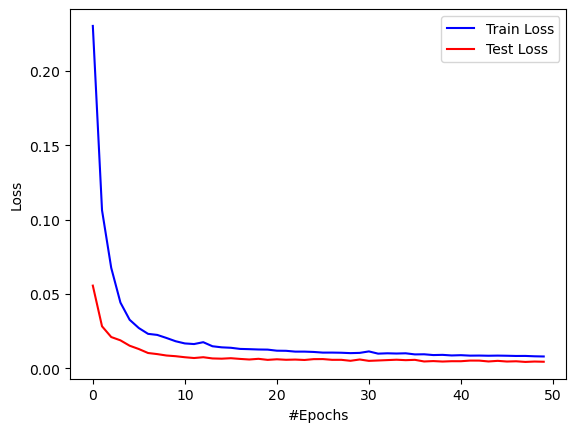

In [23]:
##Training parameters
num_epochs = 50
print_interval = 1
learning_rate = 1e-3
batch_size = 100
kernel_size = 3
window_size=24

#Create model
network = MF_CNN()
#state_dict = torch.load("msi_model.pth", weights_only=True)
#network.load_state_dict(state_dict, strict=True)
network = network.to(device)

#Set optimizer and loss function
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
loss_function = nn.MSELoss()

#Load the data, and split it into batches

print("Loaded Data")

trainAndGraph(network, train_loader, val_loader, loss_function, optimizer, num_epochs, learning_rate, print_interval)
# train_model(network, train_loader, val_loader, lr=1e-3, n_epochs=20, patience=10, device='cpu')

mse, rmse, mae, preds, true = computeRegressionMetrics(network, train_loader, "Train Set", target_scaler=target_scaler)
t_mse, t_rmse, t_mae, t_preds, t_true = computeRegressionMetrics(network, val_loader, "Test Set", target_scaler=target_scaler)

In [19]:
model = MF_CNN()
#state_dict = torch.load("msi_model.pth", weights_only=True)
state_dict = torch.load("msi_model_FINAL.pth", weights_only=True)
model.load_state_dict(state_dict, strict=True)
model.eval()

all_preds = []
all_true  = []

with torch.no_grad():
    for cont, daily, weekly, y in test_loader:
        preds = model(cont, daily, weekly)

        all_preds.append(preds)
        all_true.append(y)

all_preds = torch.cat(all_preds).numpy()
all_true  = torch.cat(all_true).numpy()


In [20]:
mse_loss = ((all_preds - all_true) ** 2).mean()
rmse = mse_loss ** 0.5
mae_loss = (abs(all_preds - all_true)).mean()

print(f"MSE: {mse_loss:.4f}, RMSE: {rmse:.4f}, MAE: {mae_loss:.4f}")

MSE: 0.0044, RMSE: 0.0662, MAE: 0.0427


<Axes: >

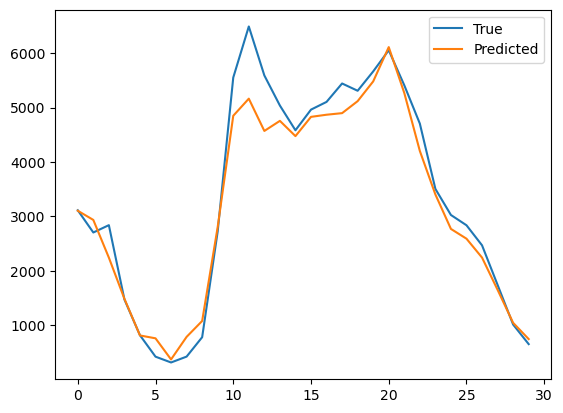

In [21]:
x = np.arange(30)
preds = target_scaler.inverse_transform(all_preds)
trues = target_scaler.inverse_transform(all_true)
sns.lineplot(x=x, y=trues[:30].flatten(), label="True")
sns.lineplot(x=x, y=preds[:30].flatten(), label="Predicted")

In [27]:
mse_loss = ((preds - trues) ** 2).mean()
rmse = mse_loss ** 0.5
mae_loss = (abs(preds - trues)).mean()
mape = np.mean(np.abs((trues - preds)) / trues) * 100

print(f"MSE: {mse_loss:.4f}, RMSE: {rmse:.4f}, MAE: {mae_loss:.4f}, MAPE: {mape:.4f}")

MSE: 250498.4844, RMSE: 500.4982, MAE: 342.3469, MAPE: 18.9736


In [96]:
# Check shapes
print(t_preds.shape, t_true.shape)

# Check MinMaxScaler range
print(target_scaler.data_min_, target_scaler.data_max_)

# Compute MSE in scaled units
mse_scaled = ((all_preds - all_true)**2).mean()
print("MSE scaled:", mse_scaled)

# Compute MSE in original units
preds_orig = target_scaler.inverse_transform(all_preds)
trues_orig = target_scaler.inverse_transform(all_true)
mse_orig = ((preds_orig - trues_orig)**2).mean()
print("MSE original:", mse_orig)


(7779,) (7779,)
[0.] [7260.]
MSE scaled: 0.004379349
MSE original: 230824.95


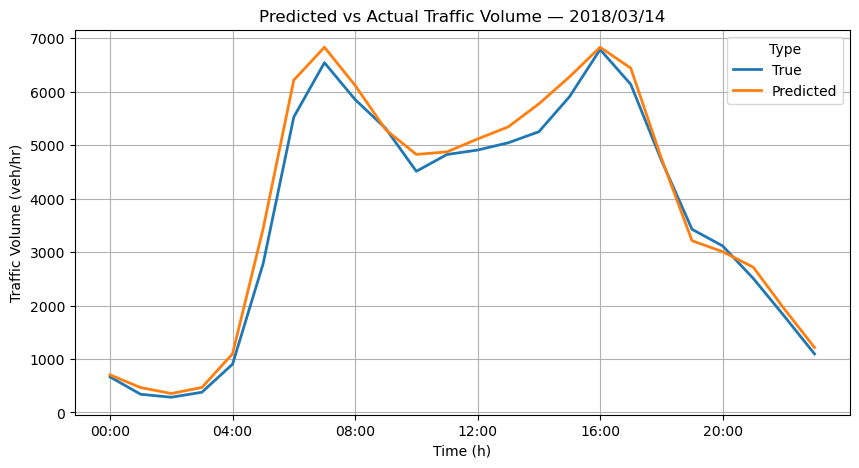

In [51]:
df_plot = pd.DataFrame({
    "Hour": np.arange(24),
    "True": trues[2970:2994].flatten(),
    "Predicted": preds[2970:2994].flatten(),
})

df_plot = df_plot.melt(id_vars="Hour", 
                       value_vars=["True", "Predicted"],
                       var_name="Type", 
                       value_name="TrafficVolume")

plt.figure(figsize=(10, 5))
sns.lineplot(data=df_plot, x="Hour", y="TrafficVolume", hue="Type", linewidth=2)

plt.title(f"Predicted vs Actual Traffic Volume — 2018/03/14")
plt.xlabel("Time (h)")
plt.ylabel("Traffic Volume (veh/hr)")
plt.grid(True)
ticks=np.arange(0, 24, 4)
plt.xticks(ticks=ticks,
           labels=[f"{h:02d}:00" for h in ticks])
plt.show()

In [25]:
df['date'] = df.index.date.astype(str)
print(np.where(df['date'] == '2018-03-11'))
print(np.where(df['date'] == '2018-03-17'))

(array([35695, 35696, 35697, 35698, 35699, 35700, 35701, 35702, 35703,
       35704, 35705, 35706, 35707, 35708, 35709, 35710, 35711, 35712,
       35713, 35714, 35715, 35716, 35717]),)
(array([35836, 35837, 35838, 35839, 35840, 35841, 35842, 35843, 35844,
       35845, 35846, 35847, 35848, 35849, 35850, 35851, 35852, 35853,
       35854, 35855, 35856, 35857, 35858, 35859]),)


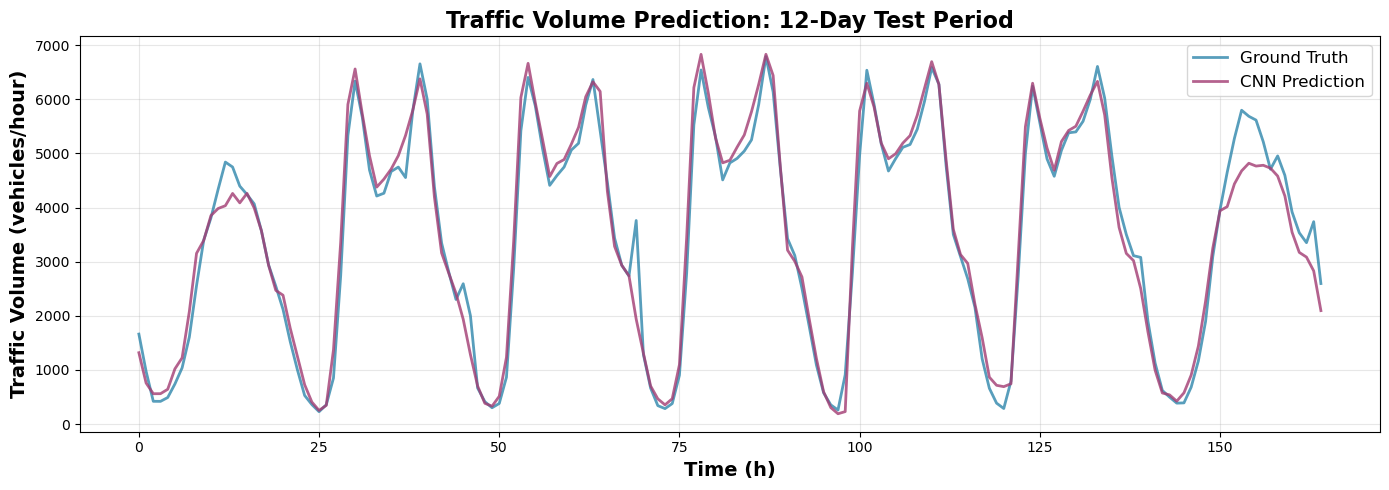

In [28]:
fig, ax = plt.subplots(figsize=(14, 5))
    
hours = np.arange(len(trues[2899:3064]))
ax.plot(hours, trues[2899:3064], label='Ground Truth', color='#2E86AB', linewidth=2, alpha=0.8)
ax.plot(hours, preds[2899:3064], label='CNN Prediction', color='#A23B72', linewidth=2, alpha=0.8)

# Style
ax.set_xlabel('Time (h)', fontsize=14, fontweight='bold')
ax.set_ylabel('Traffic Volume (vehicles/hour)', fontsize=14, fontweight='bold')
ax.set_title('Traffic Volume Prediction: 12-Day Test Period', fontsize=16, fontweight='bold')
ax.legend(fontsize=12, loc='upper right')
ax.grid(True, alpha=0.3)

# Add shaded regions for weekends (if you know the dates)
# for start in [48, 168, 240]:  # Example weekend starts
#     ax.axvspan(start, start+48, alpha=0.1, color='gray', label='Weekend' if start==48 else '')

plt.tight_layout()
#plt.savefig('prediction_vs_actual.png', dpi=300, bbox_inches='tight')
plt.show()

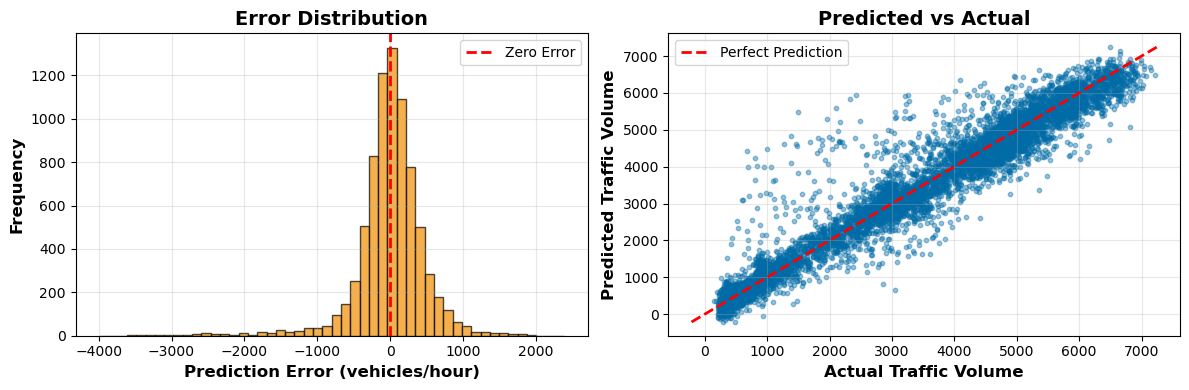

In [29]:
errors = trues - preds
    
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
axes[0].hist(errors, bins=50, color='#F18F01', alpha=0.7, edgecolor='black')
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[0].set_xlabel('Prediction Error (vehicles/hour)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Error Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Scatter plot: Predicted vs Actual
axes[1].scatter(trues, preds, alpha=0.4, s=10, color='#006BA6')

# Perfect prediction line
min_val = min(trues.min(), preds.min())
max_val = max(trues.max(), preds.max())
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

axes[1].set_xlabel('Actual Traffic Volume', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Predicted Traffic Volume', fontsize=12, fontweight='bold')
axes[1].set_title('Predicted vs Actual', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
#plt.savefig('error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()